In [1]:
import os
import numpy as np
import random
import pickle
import copy
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import KFold
import h5py

np.random.seed(0)
random.seed(0)

In [34]:
new_num_kfolds = 7
NUM_CLIENTS = 14
local_round_threshold = 20
num_usuable_updates = 7

In [3]:
# INTRA
'09-19_22-56_NOFL'
'09-19_23-04_FEDAVG' 
'09-19_23-05_PFAFO_GDLS'

# CROSS
'09-19_23-07_PFAFO_GDLS'
'09-19_23-25_FEDAVG'
'09-19_23-30_NOFL'

'09-19_23-30_NOFL'

In [4]:
# CROSS

cv_results_path = r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results\FinalSims"
nofl_filename = "FULLSCIPYMIN_NOFL_KFold0.h5" 
fedavg_filename = "GDLS_FEDAVG_KFold0.h5" 

directory_str = "09-19_23-25_FEDAVG"
h5_path = os.path.join(cv_results_path, directory_str, fedavg_filename)
with h5py.File(h5_path, 'r') as f:
    a_group_key = list(f.keys())#[0]
    print(a_group_key)

    local_test_error_log = f['local_test_error_log'][()]
    local_train_error_log = f['local_train_error_log'][()]
    
    client_local_model_log_keys = list(f['client_local_model_log'].keys())
    #print("Keys in 'client_local_test_log':", client_local_model_log_keys)
    client_local_model_log_data = {}
    for key in client_local_model_log_keys:
        try:
            client_local_model_log_data[key] = f['client_local_model_log'][key][:]
        except KeyError:
            pass
            
    client_local_test_log_keys = list(f['client_local_test_log'].keys())
    # Iterate over the keys and extract the corresponding data
    client_local_test_log_data = {}
    for key in client_local_test_log_keys:
        client_local_test_log_data[key] = f['client_local_test_log'][key][:]

    client_gradnorm_log_keys = list(f['gradient_norm_lists_by_client'].keys())
    # Iterate over the keys and extract the corresponding data
    client_gradnorm_log_data = {}
    for key in client_gradnorm_log_keys:
        client_gradnorm_log_data[key] = f['gradient_norm_lists_by_client'][key][:]

    if "FEDAVG" in directory_str:
        global_dec_log = f['global_dec_log'][()]


['client_local_model_log', 'client_local_test_log', 'global_dec_log', 'global_test_error_log', 'global_train_error_log', 'gradient_norm_lists_by_client', 'local_test_error_log', 'local_train_error_log']


In [5]:
client_local_model_log_keys

['S0_client_local_model_log',
 'S10_client_local_model_log',
 'S11_client_local_model_log',
 'S12_client_local_model_log',
 'S13_client_local_model_log',
 'S1_client_local_model_log',
 'S2_client_local_model_log',
 'S3_client_local_model_log',
 'S4_client_local_model_log',
 'S5_client_local_model_log',
 'S6_client_local_model_log',
 'S7_client_local_model_log',
 'S8_client_local_model_log',
 'S9_client_local_model_log']

In [8]:
for i in range(NUM_CLIENTS):
    print(client_local_model_log_data[client_local_model_log_keys[i]].shape)

(1, 2, 64)
(105, 2, 64)
(105, 2, 64)
(114, 2, 64)
(104, 2, 64)
(1, 2, 64)
(106, 2, 64)
(103, 2, 64)
(104, 2, 64)
(106, 2, 64)
(101, 2, 64)
(104, 2, 64)
(105, 2, 64)
(105, 2, 64)


In [9]:
global_dec_log.shape

(251, 2, 64)

## Mutual Information

In [10]:
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mutual_info_score
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression

In [14]:
import os
import random
import pickle

path = r'C:\Users\kdmen\Desktop\Research\Data\CPHS_EMG'
model_saving_dir = r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\models"
cond0_filename = r'\cond0_dict_list.p'

np.random.seed(0)
random.seed(0)

with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)

In [12]:
NUM_CLIENTS = 14
update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]
STARTING_UPDATE = 10
starting_update_ix = update_ix[STARTING_UPDATE]
final_usable_update = 17
final_usable_update_ix = update_ix[final_usable_update]
adj_update_ix = np.array(update_ix[STARTING_UPDATE:final_usable_update]) - starting_update_ix
print(adj_update_ix)

[   0 1202 2404 3606 4808 6010 7212]


In [16]:
client_data = dict()
client_labels = dict()
# Sets the full data and label sets for each client
for i in range(NUM_CLIENTS):
    client_data[i] = cond0_training_and_labels_lst[i]['training'][starting_update_ix:final_usable_update_ix, :]
    client_labels[i] = cond0_training_and_labels_lst[i]['labels'][starting_update_ix:final_usable_update_ix, :]

upper_bound = 1202
lower_bound = 0

# Need to edit each update so taht it is preprocessed (eg normalized, for PFA create 2 batches?)
## And need to divide each into updates, right now is just a full matrix
## Create F, v, p, etc? ... I think I'm only using F...

In [20]:
for i in range(NUM_CLIENTS):
    print(f"Cli {i}: Dataset shape {client_data[i].shape}, divisible by 1202? {client_data[i].shape[0]/1202}")

Cli 0: Dataset shape (8414, 64), divisible by 1202? 7.0
Cli 1: Dataset shape (8414, 64), divisible by 1202? 7.0
Cli 2: Dataset shape (8414, 64), divisible by 1202? 7.0
Cli 3: Dataset shape (8414, 64), divisible by 1202? 7.0
Cli 4: Dataset shape (8414, 64), divisible by 1202? 7.0
Cli 5: Dataset shape (8414, 64), divisible by 1202? 7.0
Cli 6: Dataset shape (8414, 64), divisible by 1202? 7.0
Cli 7: Dataset shape (8414, 64), divisible by 1202? 7.0
Cli 8: Dataset shape (8414, 64), divisible by 1202? 7.0
Cli 9: Dataset shape (8414, 64), divisible by 1202? 7.0
Cli 10: Dataset shape (8414, 64), divisible by 1202? 7.0
Cli 11: Dataset shape (8414, 64), divisible by 1202? 7.0
Cli 12: Dataset shape (8414, 64), divisible by 1202? 7.0
Cli 13: Dataset shape (8414, 64), divisible by 1202? 7.0


In [ ]:
# Thus, everything is already partitioned into the updates of size 1202 for me, and the 7 folds

In [25]:
client_F_dict = dict()
for i in range(NUM_CLIENTS):
    client_dataset = client_data[i]
    cli_F_lst = []

    chunk_size = 1202
    for j in range(0, len(client_dataset), chunk_size):
        s_temp = client_dataset[j:j + chunk_size]

        #s_temp = copy.deepcopy(self.training_data[lower_bound:upper_bound,:])
        #self.p_reference = copy.deepcopy(np.transpose(self.training_labels[lower_bound:upper_bound,:]))
            
        if "PFA" in directory_str:
            mid_point = upper_bound//2
            s_temp2 = copy.deepcopy(s_temp[mid_point:upper_bound,:])
            s_temp = copy.deepcopy(s_temp[lower_bound:mid_point,:])

            s_normed = s_temp/np.amax(s_temp)
            s = np.transpose(s_normed)
            F = s[:,:-1] # note: truncate F for estimate_decoder
            #v_actual = self.w@self.s
            #p_actual = np.cumsum(v_actual, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
            
            #self.p_reference2 = copy.deepcopy(np.transpose(self.training_labels[mid_point:upper_bound,:]))
            s_normed2 = s_temp2/np.amax(s_temp2)
            s2 = np.transpose(s_normed2)
            F2 = self.s2[:,:-1] # note: truncate F for estimate_decoder
            #v_actual2 = self.w@self.s2
            #p_actual2 = np.cumsum(v_actual2, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
            
            cli_F_lst.append(F)
            cli_F_lst.append(F2)
        else:
            s_normed = s_temp/np.amax(s_temp)
            s = np.transpose(s_normed)
            F = s[:,:-1] # note: truncate F for estimate_decoder
            cli_F_lst.append(F)
    
    client_F_dict[i] = copy.deepcopy(cli_F_lst)


In [46]:
# Find the longest array based on shape[0]
max_length = max(client_local_model_log_data[key].shape[0] for key in client_local_model_log_keys)
# Generate the indices for equally spaced sampling from global_dec_log
indices = np.linspace(0, len(global_dec_log) - 1, max_length).astype(int)
# Sample global_dec_log to match the length of the longest client array
sampled_global_dec_log = global_dec_log[indices]

In [48]:
# So now I need to link each set of 20 consecutive models to each update. Eg 1-20-->F1, 21-40-->F2, ... 140+-->F7 (might not get to F7!)
## So it should iterative through consecutive models

cli_mi_local = {i: [] for i in range(NUM_CLIENTS)}
cli_mi_global = {i: [] for i in range(NUM_CLIENTS)}
for i in range(NUM_CLIENTS):
    cli_i_model_log = client_local_model_log_data[client_local_model_log_keys[i]]
    if cli_i_model_log.shape[0]<2:
        # Client didnt train (eg it was probably a testset client)
        print(f"Cli {i} skipped for being too short!")
    else:
        for model_idx, model in enumerate(cli_i_model_log):
            # Models and dataset may not be aligned
            ## Eg some may be saved in order of 0, 10, 11, 12, 13, 1, ... whereas the other may be saved as 0, 1, 2, 3, ...

            if model_idx > local_round_threshold * num_usuable_updates:
                input_index = 7
            else:
                input_index = model_idx // local_round_threshold
            # Access the corresponding input for this chunk
            X_train = client_F_dict[i][input_index]  # TODO: THIS DOES NOT SUPPORT 2 BATCH PFA RIGHT NOW!
            #print(f"Model idx: {model_idx}; Update (input) index: {input_index}'")

            # COMPARE EACH LOCAL MODEL TO THE TRAINING DATA TO GENERATE A MUTUAL INFORMATION CURVE
            # Step 1: Dimensionality reduction of training data using PCA
            # Reduce X_train to 2 dimensions to match model weights shape
            pca = PCA(n_components=2)
            X_train_PCA = pca.fit_transform(X_train).flatten()
            
            # Step 2: Compute mutual information between reduced training data and local model weights
            cli_mi_local[i].append(mutual_info_regression(X_train_PCA, model.flatten()))
            
            # COMPARE EACH GLOBAL MODEL (from the adjusted list) TO THE TRAINING DATA
            #if model_idx%20==0:
            cli_mi_global.append(mutual_info_regression(X_train_PCA, sampled_global_dec_log[model_idx].flatten()))

Cli 0 skipped for being too short!


ValueError: Expected 2D array, got 1D array instead:
array=[ 1.61853578 -0.05241973 -1.48932333 -0.03775793 -1.46250113 -0.036605
 -0.65015244 -0.16457455 -0.68384152 -0.17121581  2.31732347 -0.17282482
  2.32191697 -0.18583318  1.63069617 -0.18500374  1.60433625 -0.18605728
 -1.64564529 -0.04443971  0.87458748 -0.10993016  0.8837154  -0.11026909
  0.97318932 -0.12709926 -1.34630024 -0.08066563  1.23202806 -0.15725434
 -1.68915978 -0.04626251  1.96575053 -0.20341307  1.97050534 -0.20357212
  2.7377672  -0.12491077  2.68156069 -0.12567602  2.11714516 -0.19398344
 -0.45689085  0.01854197 -0.50499446 -0.00899143 -0.9180853  -0.01595032
 -0.99811455 -0.025854   -0.91314379 -0.04796634 -0.78707961 -0.05559237
 -0.61341076 -0.05028045  2.25510326 -0.20158185 -1.73259247 -0.0481771
  0.25866457  2.39435427  1.20565099  2.57477129  2.37219268  0.08577424
  1.38139628 -0.17867383  1.40222057 -0.17883229  0.93540244 -0.12392266
  0.90661241 -0.12226623 -1.72373686 -0.04784751 -1.73009022 -0.04804858
 -1.67485285 -0.04566534 -1.01010666 -0.0215415  -1.73252557 -0.04816405
 -1.65697339 -0.04483903 -1.73894638 -0.04853015  2.92612954 -0.13440427
 -1.0395642   0.03294817 -1.68351376 -0.04596925 -1.70277606 -0.04688709
 -1.59139136 -0.04200064 -1.52251007 -0.03910005 -1.12091831 -0.0320706
 -1.37260422 -0.03257889 -1.68905575 -0.0463121   2.92571137 -0.00901796
  2.88524859 -0.00426114 -1.72340098 -0.04770045 -1.69602713 -0.0464844
  2.27768428 -0.13796515  0.0687447  -0.06946914  1.46174308 -0.14173927
 -1.67633734 -0.04567148 -1.53284172 -0.03951662 -1.3157556  -0.03018443
 -1.36639865 -0.0325638 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# Dummy training data (64 examples, 1202 features)
X_train = np.random.rand(64, 1202)

# Dummy local model weights (64 examples, 2 features)
client_local_model_weights = np.random.rand(64, 2)

# Dummy global model weights (64 examples, 2 features)
global_model_weights = np.random.rand(64, 2)

# Step 1: Compute summary statistics for each example in X_train
# Let's use mean and variance as our summary statistics
X_train_summary = np.vstack([np.mean(X_train, axis=1), np.var(X_train, axis=1)]).T  # Shape: (64, 2)

# Step 2: Compute mutual information between summary statistics and local model weights
mi_local = []
for i in range(client_local_model_weights.shape[1]):
    mi_local.append(mutual_info_regression(X_train_summary, client_local_model_weights[:, i]))

# Step 3: Compute mutual information between summary statistics and global model weights
mi_global = []
for i in range(global_model_weights.shape[1]):
    mi_global.append(mutual_info_regression(X_train_summary, global_model_weights[:, i]))

# Output mutual information scores
print("Mutual Information (summary stats) between X_train and local model weights:", mi_local)
print("Mutual Information (summary stats) between X_train and global model weights:", mi_global)


In [ ]:
# Helper function to compute entropy using KDE
def kde_entropy(X, bandwidth=1.0):
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(X)
    log_density = kde.score_samples(X)
    return -np.mean(log_density)

# Helper function to compute mutual information using KDE
def kde_mutual_information(X, Y, bandwidth=1.0):
    # Joint entropy H(X,Y)
    XY = np.hstack([X, Y])
    joint_entropy = kde_entropy(XY, bandwidth)
    
    # Marginal entropies H(X) and H(Y)
    entropy_X = kde_entropy(X, bandwidth)
    entropy_Y = kde_entropy(Y, bandwidth)
    
    # MI = H(X) + H(Y) - H(X,Y)
    mutual_info = entropy_X + entropy_Y - joint_entropy
    return mutual_info

# Dummy training data (64 examples, 1202 features)
X_train = np.random.rand(64, 1202)

# Dummy local model weights (64 examples, 2 features)
client_local_model_weights = np.random.rand(64, 2)

# Dummy global model weights (64 examples, 2 features)
global_model_weights = np.random.rand(64, 2)

# Step 1: Reduce the training data dimensionality using PCA to match model weights (optional, depending on your scenario)
# Alternatively, you can use summary statistics, but let's use PCA here for KDE method
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)

# Step 2: Compute KDE-based mutual information between reduced training data and local model weights
mi_local_kde = kde_mutual_information(X_train_reduced, client_local_model_weights)

# Step 3: Compute KDE-based mutual information between reduced training data and global model weights
mi_global_kde = kde_mutual_information(X_train_reduced, global_model_weights)

# Output mutual information scores
print("KDE-based Mutual Information between X_train and local model weights:", mi_local_kde)
print("KDE-based Mutual Information between X_train and global model weights:", mi_global_kde)


## Membership Inference Attack

In [52]:
# CROSS

cv_results_path = r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results"
nofl_filename = "FULLSCIPYMIN_NOFL_KFold0.h5" 
fedavg_filename = "GDLS_FEDAVG_model_without_users_0_and_1.h5" 

directory_str = "09-24_18-46_FEDAVG"
h5_path = os.path.join(cv_results_path, directory_str, fedavg_filename)
with h5py.File(h5_path, 'r') as f:
    a_group_key = list(f.keys())#[0]
    print(a_group_key)

    local_test_error_log = f['local_test_error_log'][()]
    local_train_error_log = f['local_train_error_log'][()]
    
    client_local_model_log_keys = list(f['client_local_model_log'].keys())
    #print("Keys in 'client_local_test_log':", client_local_model_log_keys)
    client_local_model_log_data = {}
    for key in client_local_model_log_keys:
        try:
            client_local_model_log_data[key] = f['client_local_model_log'][key][:]
        except KeyError:
            pass
            
    client_local_test_log_keys = list(f['client_local_test_log'].keys())
    # Iterate over the keys and extract the corresponding data
    client_local_test_log_data = {}
    for key in client_local_test_log_keys:
        client_local_test_log_data[key] = f['client_local_test_log'][key][:]

    client_gradnorm_log_keys = list(f['gradient_norm_lists_by_client'].keys())
    # Iterate over the keys and extract the corresponding data
    client_gradnorm_log_data = {}
    for key in client_gradnorm_log_keys:
        client_gradnorm_log_data[key] = f['gradient_norm_lists_by_client'][key][:]

    if "FEDAVG" in directory_str:
        global_dec_log = f['global_dec_log'][()]


['client_local_model_log', 'client_local_test_log', 'global_dec_log', 'global_test_error_log', 'global_train_error_log', 'gradient_norm_lists_by_client', 'local_test_error_log', 'local_train_error_log']


In [55]:
with open(cv_results_path+f"\\{directory_str}\\membership_inference_results.pkl", 'rb') as f:
    membership_inference_results = pickle.load(f)

In [56]:
membership_inference_results

{'model_without_users_0_and_1': [0.2111205,
  0.1223625,
  0.0002366,
  0.0002401,
  0.0002381,
  0.0002481,
  0.0002519,
  0.0002145,
  0.0001992,
  0.0002242,
  0.0001864,
  0.0002175,
  0.0001975,
  0.000222],
 'model_without_users_0_and_2': [0.211437,
  0.000273,
  0.0363288,
  0.0002672,
  0.0002371,
  0.000247,
  0.0002525,
  0.0002142,
  0.0001992,
  0.0002122,
  0.0001873,
  0.0002171,
  0.0001974,
  0.0002222],
 'model_without_users_0_and_3': [0.2114938,
  0.0002728,
  0.0002426,
  0.316108,
  0.0002377,
  0.0002479,
  0.0002502,
  0.0002003,
  0.000199,
  0.0002236,
  0.0001864,
  0.0002177,
  0.0001975,
  0.0001969],
 'model_without_users_0_and_4': [0.2109569,
  0.0002757,
  0.0002448,
  0.0002416,
  0.075253,
  0.0002495,
  0.0002507,
  0.0002005,
  0.0001999,
  0.0002129,
  0.0001869,
  0.0002196,
  0.0001987,
  0.0002224]}

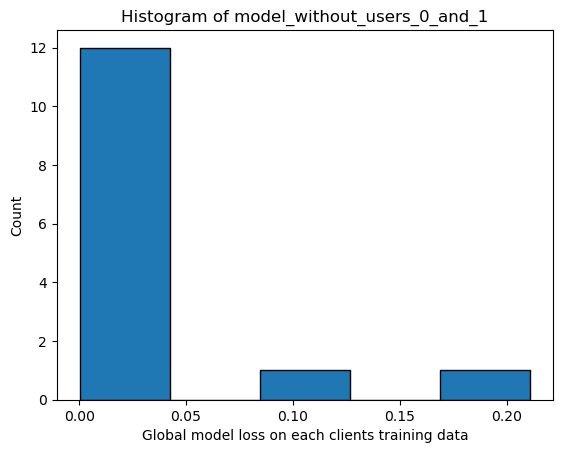

In [64]:
key0 = list(membership_inference_results.keys())[0]

plt.hist(membership_inference_results[key0], bins=5, edgecolor='black')
# Add labels and title
plt.xlabel('Global model loss on each clients training data')
plt.ylabel('Count')
plt.title('Histogram of model_without_users_0_and_1')
plt.show()

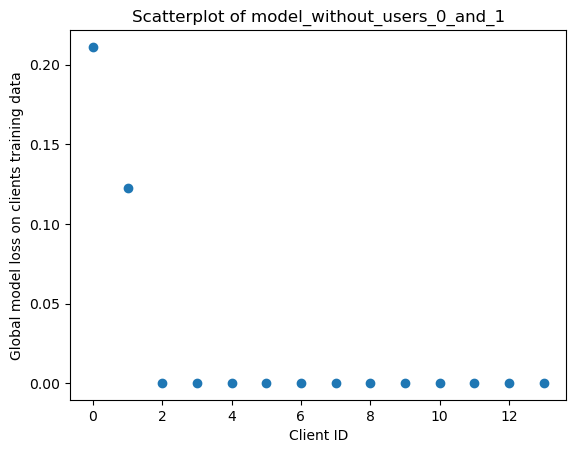

In [65]:
plt.scatter(range(len(membership_inference_results[key0])), membership_inference_results[key0])
plt.xlabel('Client ID')
plt.ylabel('Global model loss on clients training data')
plt.title('Scatterplot of model_without_users_0_and_1')
plt.show()

Now I am stuck, I am not sure how to train a membership inference model. I feed it the loss from each client and the label of it that sample was in the dataset? For all clients at once or just a single client membership inference per model? ...

In [66]:
# Initialize an empty dictionary to store the new mappings
model_without_single_user_dict = {f"model_without_user_{i}": [] for i in range(NUM_CLIENTS)}  # For users 0 to 13

# Iterate through each key and its corresponding value in the original dictionary
for key, model_list in membership_inference_results.items():
    # Extract the user numbers from the key (format "model_without_users_X_and_Y")
    users_str = key.replace("model_without_users_", "")
    user_IDs = list(map(int, users_str.split('_and_')))

    # Add the model list to the new dictionary for both users
    for user in user_IDs:
        model_without_single_user_dict[f"model_without_user_{user}"].append(model_list)

# Optional: Remove duplicates in each list (if necessary)
#for key, model_list in new_dict.items():
#    new_dict[key] = list(set(model_list))  # Remove duplicates


In [67]:
model_without_single_user_dict

{'model_without_user_0': [[0.2111205,
   0.1223625,
   0.0002366,
   0.0002401,
   0.0002381,
   0.0002481,
   0.0002519,
   0.0002145,
   0.0001992,
   0.0002242,
   0.0001864,
   0.0002175,
   0.0001975,
   0.000222],
  [0.211437,
   0.000273,
   0.0363288,
   0.0002672,
   0.0002371,
   0.000247,
   0.0002525,
   0.0002142,
   0.0001992,
   0.0002122,
   0.0001873,
   0.0002171,
   0.0001974,
   0.0002222],
  [0.2114938,
   0.0002728,
   0.0002426,
   0.316108,
   0.0002377,
   0.0002479,
   0.0002502,
   0.0002003,
   0.000199,
   0.0002236,
   0.0001864,
   0.0002177,
   0.0001975,
   0.0001969],
  [0.2109569,
   0.0002757,
   0.0002448,
   0.0002416,
   0.075253,
   0.0002495,
   0.0002507,
   0.0002005,
   0.0001999,
   0.0002129,
   0.0001869,
   0.0002196,
   0.0001987,
   0.0002224]],
 'model_without_user_1': [[0.2111205,
   0.1223625,
   0.0002366,
   0.0002401,
   0.0002381,
   0.0002481,
   0.0002519,
   0.0002145,
   0.0001992,
   0.0002242,
   0.0001864,
   0.0002175,
  

In [ ]:
import numpy as np
from scipy.stats import norm

# Example values
conf_obs = 0.8  # Example confidence score
mu_in = 0.7
sigma_in = 0.1
mu_out = 0.5
sigma_out = 0.2

# Calculate the probability densities
p_in = norm.pdf(conf_obs, mu_in, sigma_in)
p_out = norm.pdf(conf_obs, mu_out, sigma_out)

# Calculate G
G = p_in / p_out

print(f"G = {G}")


How to make MIA work for my FL case <br>
Also for Local... allegedly, between INTRA and CROSS, the local models should actually be the same (as long as the model didn't advance all the way to the final updates where the cut is in INTRA, although that probably happened, although is likely a miniscule effect). So this approach would then allow me to tell from what user the local model came from. So presumably, Local will have good defense against interception based attacks (eg ones that use model weights to classify models to users) but will get BTFOd by membership inference attacks. MIA is ofc a much more involved attack.

In [50]:
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
# Function to simulate membership inference attack
def membership_inference_attack(client_models, X_train, X_test, y_train, y_test):
    shadow_model = train_shadow_model(client_models, X_train, y_train)
    attack_model = train_attack_model(shadow_model, X_train, X_test, y_train, y_test)
    
    # Predict membership for some test data
    y_pred = attack_model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Function to train shadow model
def train_shadow_model(client_models, X_train, y_train):
    # Simulate using the client models to mimic the behavior of the original model
    shadow_model = ClientModel()
    shadow_model.train(X_train, y_train)
    return shadow_model

# Function to train attack model (classifier predicting membership status)
def train_attack_model(shadow_model, X_train, X_test, y_train, y_test):
    attack_X_train, attack_X_test, attack_y_train, attack_y_test = create_attack_dataset(shadow_model, X_train, X_test)
    attack_model = AttackModel()
    attack_model.train(attack_X_train, attack_y_train)
    return attack_model

# Function to create attack dataset from shadow model outputs
def create_attack_dataset(shadow_model, X_train, X_test):
    train_confidences = shadow_model.predict_proba(X_train)
    test_confidences = shadow_model.predict_proba(X_test)
    
    attack_X = np.concatenate([train_confidences, test_confidences])
    attack_y = np.concatenate([np.ones(len(train_confidences)), np.zeros(len(test_confidences))])
    
    return train_test_split(attack_X, attack_y, test_size=0.5)

# Example usage
client_models = [ClientModel() for _ in range(14)]  # Placeholder for client models

# Assuming you have X_train, y_train, X_test, y_test already loaded
membership_inference_acc = membership_inference_attack(client_models, X_train, X_test, y_train, y_test)
print(f"Membership Inference Attack Accuracy: {membership_inference_acc}")


In [ ]:
for client_id in range(14):
    for model_id in range(100):
        model = client_models[client_id][model_id]
        
        # Membership Inference
        membership_inference_acc = membership_inference_attack(client_models, X_train, X_test, y_train, y_test)
        
        # Model Inversion
        target_output = model.predict(some_input)  # Select some target output
        inverted_input = model_inversion_attack(model, target_output, input_shape)
        
        print(f"Client {client_id}, Model {model_id}, Membership Inference Acc: {membership_inference_acc}")


## Model Inversion Attack

In [ ]:
if False:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    
    # Function to perform model inversion attack
    def model_inversion_attack(model, target_output, input_shape, num_iterations=1000, learning_rate=1e-2):
        # Initialize input (with random noise)
        inverted_input = torch.randn(input_shape, requires_grad=True)
        optimizer = optim.Adam([inverted_input], lr=learning_rate)
        
        loss_fn = nn.MSELoss()
        
        for i in range(num_iterations):
            optimizer.zero_grad()
            output = model(inverted_input)
            loss = loss_fn(output, target_output)
            loss.backward()
            optimizer.step()
        
        return inverted_input.detach()
    
    # Example usage
    client_models = [ClientModel() for _ in range(14)]  # Placeholder for client models
    target_model = client_models[0]  # Assume you are attacking the first client
    target_output = torch.tensor([0.1, 0.9])  # Target output we want to reproduce
    
    # Perform inversion attack to get reconstructed input
    inverted_input = model_inversion_attack(target_model, target_output, input_shape=(1, 28, 28))  # Example input shape (e.g. for images)
    print("Reconstructed input:", inverted_input)


In [ ]:
# Gradient Descent Model Inversion Attack on a Linear Regression Model
def model_inversion_attack(weights, target_output, input_shape, num_iterations=1000, learning_rate=0.01):
    # Initialize a random input (e.g., random noise)
    inverted_input = np.random.randn(*input_shape)
    
    for i in range(num_iterations):
        # Compute the output from the current inverted input
        output = np.dot(inverted_input, weights)
        
        # Compute the loss (Mean Squared Error between target and current output)
        loss = np.mean((output - target_output) ** 2)
        
        # Compute gradient of the loss with respect to the input
        grad = 2 * np.dot((output - target_output), weights.T) / len(target_output)
        
        # Update the inverted input by moving in the direction of the negative gradient
        inverted_input -= learning_rate * grad
        
        if i % 100 == 0:  # Print loss every 100 iterations
            print(f"Iteration {i}, Loss: {loss}")
    
    return inverted_input

# Example usage:
np.random.seed(42)

# Assume a simple linear regression model (2 features, 1 target)
weights = np.array([[2.0, -1.0]]).T  # A 2x1 weight matrix

# Target output we want to reproduce
target_output = np.array([0.5])

# Perform the model inversion attack to find an input that reproduces the target output
inverted_input = model_inversion_attack(weights, target_output, input_shape=(1, 2), num_iterations=1000, learning_rate=0.01)

print("Reconstructed input:", inverted_input)
